### 1. Motivation
- **Business Case** : 
    1. You developed an app and launched it on the app store.
    2. Users are actively using it, and are leaving numerous reviews.
    3. You want to listen to their feedback carefully.
    4. Finally you improve your app to meet their needs and increase your revenue.

- **Problem** : 
    1. it can be time and energy-consuming to filter all the reviews.
    2. You may need to respond quickly to dissatisfied users to establish a positive impression.
    
- **Solution** :
    1. Automate the review filtering process to focus on the most relevant feedback, especially the ones that could potentially harm your app's reputation.
    
**Note**: The breakdown provided is subjective. If there are any important aspects I've missed or if you have any feedback, please let me know :).

---

### 2. Plan of attack
1. Begin with the data, and find relevant review datasets for our use case.
    - Luckily we have Google Play Store reviews on the [Kaggle Dataset](https://www.kaggle.com/datasets/prakharrathi25/google-play-store-reviews/data)
2. Train (or fine-tune) a machine learning model on the data to analyze reviews for us.
3. Use the model to filter reviews quickly and help us respond quickly to dissatisfied reviews.
4. Potentially extract user feedback insights to help us improve our app. (but that's out of the scope of this notebook)


---

### 3. Data

In [1]:
# import
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# we will use dataset from kaggle "prakharrathi25/google-play-store-reviews"
!kaggle datasets download -d prakharrathi25/google-play-store-reviews

google-play-store-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [488]:
df = pd.read_csv("google-play-store-reviews.zip")

#### 3.1 Data Exploration

In [490]:
df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0...,Eric Tie,https://play-lh.googleusercontent.co...,I cannot open the app anymore,1,0,5.4.0.6,2020-10-27 21:24:41,NaN,NaN,newest,com.anydo
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV...,john alpha,https://play-lh.googleusercontent.co...,I have been begging for a refund fro...,1,0,NaN,2020-10-27 14:03:28,Please note that from checking our r...,2020-10-27 15:05:52,newest,com.anydo
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkP...,Sudhakar .S,https://play-lh.googleusercontent.co...,Very costly for the premium version ...,1,0,NaN,2020-10-27 08:18:40,NaN,NaN,newest,com.anydo
3,gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_...,SKGflorida@bellsouth.net DAVID S,https://play-lh.googleusercontent.co...,"Used to keep me organized, but all t...",1,0,NaN,2020-10-26 13:28:07,What do you find troublesome about t...,2020-10-26 14:58:29,newest,com.anydo
4,gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKH...,Louann Stoker,https://play-lh.googleusercontent.co...,Dan Birthday Oct 28,1,0,5.6.0.7,2020-10-26 06:10:50,NaN,NaN,newest,com.anydo
...,...,...,...,...,...,...,...,...,...,...,...,...
12490,gp:AOqpTOEQPqib7pb6vFyjMY9JEfsMs_u8W...,Mildred Olima,https://play-lh.googleusercontent.co...,"I really like the planner, it helps ...",5,0,4.5.4,2018-12-21 00:13:09,NaN,NaN,newest,com.appxy.planner
12491,gp:AOqpTOE1KKOOVVKUfhAfXQs2NfJpoywfu...,Roaring Grizzly Bear,https://play-lh.googleusercontent.co...,😁****😁,5,0,NaN,2018-12-12 21:52:56,NaN,NaN,newest,com.appxy.planner
12492,gp:AOqpTOFEn5UgYYggqiHKauDJVLLN8-16n...,amirbadang,https://play-lh.googleusercontent.co...,Very useful apps. You must try it,5,0,4.5.4,2018-12-11 15:49:43,NaN,NaN,newest,com.appxy.planner
12493,gp:AOqpTOHOH6YdYLR91qZdYpeIVkMI-LeAE...,Emma Stebbins,https://play-lh.googleusercontent.co...,Would pay for this if there were eve...,5,0,4.5.4,2018-12-06 04:59:26,NaN,NaN,newest,com.appxy.planner


- Insights:
    - at first insight, we have 12495 rows with 12 columns
    - we will ignore user/app metadata for our sentiment analysis
    - we can notice the presence of emojis
    - note: we can also factor in thumbs count for content credibility but I will go with a minimal approach here
    - So we will only focus on content and score

In [491]:
df = df[['content', 'score']]

In [492]:
# check for nulls
df.isna().sum()

content    0
score      0
dtype: int64

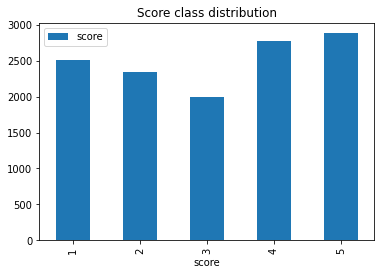

In [493]:
# check score class distribution
df.groupby('score').agg({'score':'count'}).plot(kind='bar')
plt.title("Score class distribution")
plt.show()

- Insights:
    - we can see the ratio of 3-star to and 5-star reviews is about ~2:3
    - there is imbalance but not that severe
    - so we will move forward, keeping in mind some machine learning algorithms can be sensitive to class imbalances.


- Note: if you want to improve class balance there are several ways to deal with imbalanced data including:
    1. oversample the minority
    2. undersample majority
    3. gather more labeled data from underrepresented classes


C:\Users\AAFathy\AppData\Local\Temp/ipykernel_11172/490966161.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Words per star"] = df["content"].str.split().apply(len)


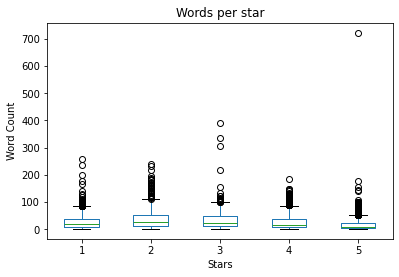

In [494]:
# check word count per star review
df["Words per star"] = df["content"].str.split().apply(len)
df.boxplot("Words per star", by="score", grid=False)
plt.suptitle("")
plt.ylabel("Word Count")
plt.xlabel("Stars")
plt.show()

- Insights:
    - we can see an indication of very high word counts compared to most of the star reviews
    - we need to have a fixed context length for our models to work properly
        - we can choose to truncate length but that can produce problems if the truncated part has crucial information for out sentiment analysis
        - we can choose to delete the very long reviews if their proportion is not significant
    - let's check that

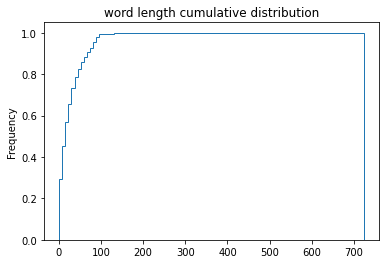

In [495]:
# cumulative distribution histogram
df['Words per star'].plot(kind='hist',bins=100,density=True, cumulative=True, histtype='step')
plt.title("word length cumulative distribution")
plt.show()

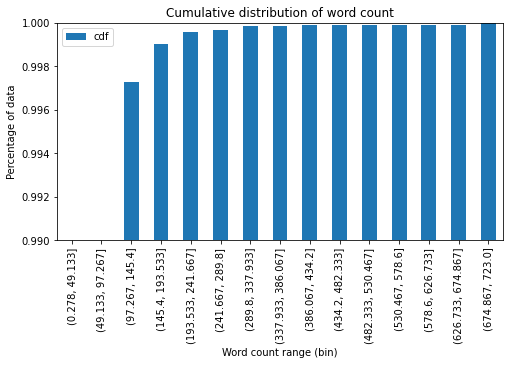

In [10]:
# more detailed view
# Frequency
bins = 15
stats_df = df.groupby(pd.cut(df['Words per star'], bins=bins))['Words per star'].agg('count').pipe(pd.DataFrame).rename(columns = {'Words per star': 'frequency'})

# PDF
stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])

# CDF
stats_df['cdf'] = stats_df['pdf'].cumsum()
stats_df = stats_df.reset_index()

stats_df.plot.bar(x = 'Words per star', y = 'cdf', figsize=(8,4))

plt.ylabel('Percentage of data')
plt.xlabel('Word count range (bin)')
plt.ylim(0.99,1.00)
plt.title("Cumulative distribution of word count")
plt.show()

- Insights:
    - more than 99.75% of reviews are below ~146 words
    - so about 0.25 % of the reviews are more than 150 words 
    - We can safely proceed with dropping the 0.25 % from our data

In [11]:
df = df.drop(df[df['Words per star'] > 150].index)

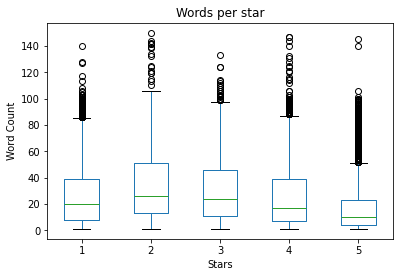

In [12]:
# lets see how word count per star review again

df["Words per star"] = df["content"].str.split().apply(len)
df.boxplot("Words per star", by="score", grid=False)
plt.suptitle("")
plt.ylabel("Word Count")
plt.xlabel("Stars")
plt.show()

- Insights:
    - after limiting our word count we see visible improvement in word count distribution
    - average word count is about ~20 words per star
    - we can still see some high word counts compared to the average but that natural to user reviews


In [13]:
# check used languages 
from ftlangdetect import detect

def detectlanguage(s):
    ''' Avoid errors generated by \n '''
    s = s.replace('\n',' ')
    return detect(s, True)['lang']

df['language'] = df['content'].apply(detectlanguage)

In [14]:
language_percentages = df.groupby(df['language'])['language'].agg('count') * 100 / len(df)

In [15]:
language_percentages[language_percentages > 0.1].sort_values(ascending=False)

language
en    97.087612
es     0.481386
pt     0.361040
ru     0.361040
fr     0.216624
de     0.200578
it     0.168485
id     0.120347
fa     0.112323
ar     0.104300
Name: language, dtype: float64

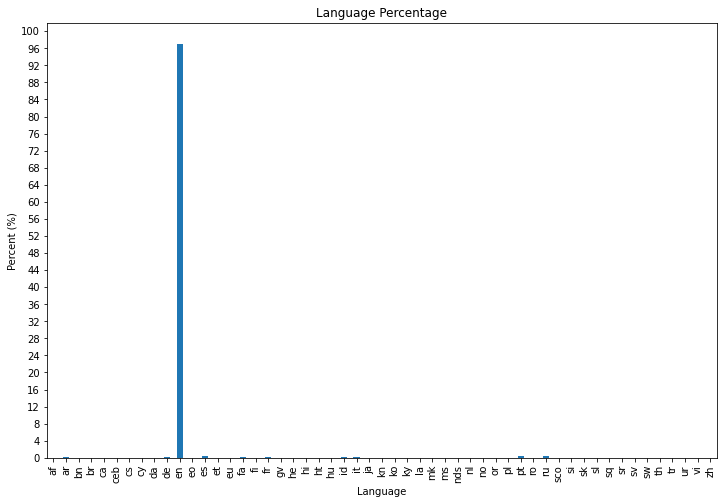

In [16]:
import numpy as np
language_percentages.plot(kind='bar',figsize=(12,8))
plt.yticks(np.arange(0, 104, step=4))
plt.ylabel('Percent (%)')
plt.xlabel('Language')
plt.title('Language Percentage')
plt.show()

- Insights:
    - we can see that more than 96% of the dataset is English language
    - this dataset will help us train a model for English language 
    - if we target other language speakers we have to find another representative dataset for the new language
    - another solution is to use cross-lingual transfer, we fine-tune the multilingual pretrained LLM on English and use it in other languages
    - we will keep it simple in this notebook and target English speakering users as the main target audience 


In [17]:
# let's take a general impression by visualizing the text content
# create corpus first
# nltk.download('stopwords')
import string
import nltk
from nltk.corpus import stopwords

stop=set(stopwords.words('english'))
corpus=[]

def get_wordlist(s):
    s_no_punct = s.translate(str.maketrans('','',string.punctuation))
    tokens = nltk.word_tokenize(s_no_punct)
    tokens = [t.lower() for t in tokens if t not in stop]
    return tokens

df['wordlist'] = df['content'].apply(get_wordlist)

corpus= df['wordlist'].explode().tolist()

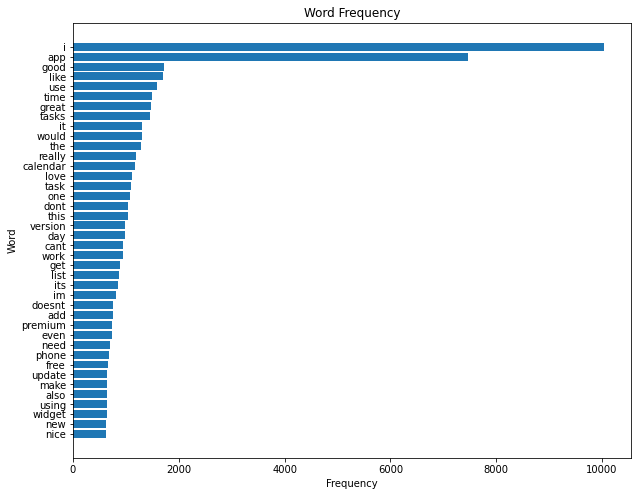

In [18]:
# visualize word frequency
from collections import Counter

counter=Counter(corpus)
most=counter.most_common()

y, width= [], []
for word,count in most[:40]:
        y.append(word)
        width.append(count)
        
plt.figure(figsize=(10,8))
plt.barh(y=y, width=width)
plt.gca().invert_yaxis()
plt.title('Word Frequency')
plt.ylabel('Word')
plt.xlabel('Frequency')
plt.show()

In [19]:
# visualize the word cloud
from wordcloud import WordCloud

def show_wordcloud(data, stopwords):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        width = 800 , height = 600,
        max_words=300,
        max_font_size=40,
        scale=4,
        random_state=1)

    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(16, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

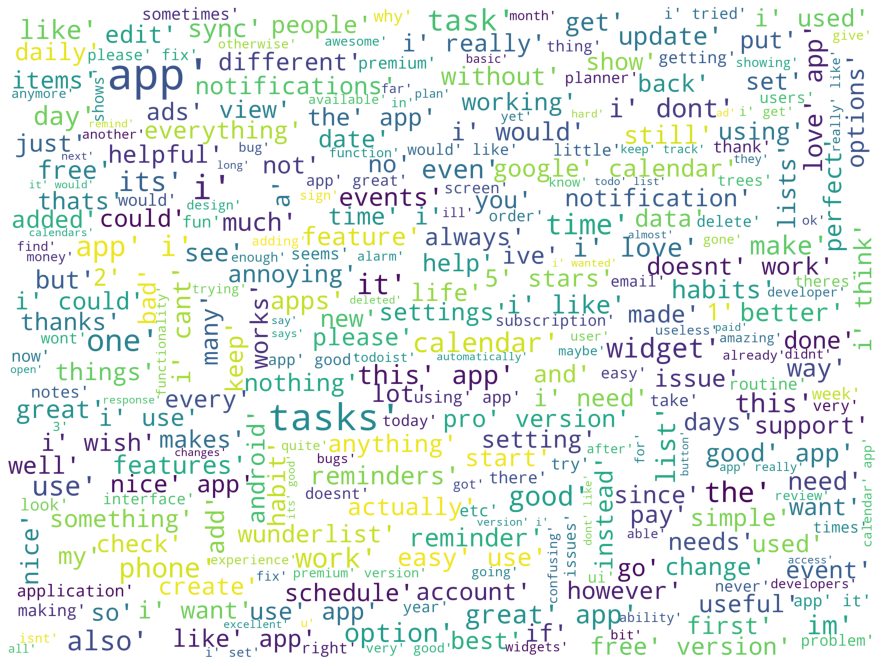

In [20]:
show_wordcloud(corpus, stop)

- Insights:
    - as expected we can see dominant words like tasks, great, app, feature, option, etc...
    - which are representative of user experience and feedback...


### 4. Method

- we will convert our classes to only 3 positive, neutral, and negative making modeling easier
    - given that our target is to filter out harmful reviews and respond to angry users
- we will build a language model to predict the review score
- first, we will use a simple baseline model as our reference
- second, we will use a pretrained large language model with an aim of improving accuracy
- before that, we need to make a train test split

#### 4.1 Preprocessing

In [393]:
# convert scores
def convert_scores(score):
    score = int(score)

    if score <= 2:
        return 0
    elif score == 3:
        return 1
    else:
        return 2

df['label'] = df['score'].apply(convert_scores)

In [394]:
# clean punctuation
df['clean_content'] = df['content'].apply(lambda x: [a for a in x if a not in string.punctuation])
df['clean_content'] = df['clean_content'].apply(''.join)
df['clean_content']

0                                                                                                                                                                                                   I cannot open the app anymore
1                                                                                                                                       I have been begging for a refund from this app for over a month and nobody is replying me
2                             Very costly for the premium version approx Indian Rupees 910 per year Better to download the premium version of this app from apkmos website and use it Microsoft to do list app is far more better
3        Used to keep me organized but all the 2020 UPDATES have made a mess of things  Y cudnt u leave well enuf alone  Guess ur techies feel the need to keep making changes to justify continuing to collect their salary  🤤🤤🤤
4                                                                                               

#### 4.2 Train test split

In [397]:
# Split into training and testing data
from sklearn.model_selection import train_test_split

x = df['clean_content']
y = df['label']

# note we use stratify=y to keep same class distribution in test and train data
X_train, X_test, y_train, y_test = train_test_split(x,y, stratify=y, test_size=0.2, random_state=42)

#### 4.2 Baseline model

In [496]:
# we will use Naive Bayes to predict our reviews
# in order to feed it with our text data we must convert it into numbers
# there are a couple of techniques for doing that
# we will use a count vectorizer as a start

In [398]:
# Count vectorizer
# Assigns the number of times a word appeared in text
# make sure to handle emojis by using the token pattern

from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(stop_words='english', token_pattern='[^\s]+')
X_train = vec.fit_transform(X_train).toarray()
X_test = vec.transform(X_test).toarray()

In [399]:
# model Naive Bayes
from sklearn.naive_bayes import MultinomialNB

nb_clf = MultinomialNB()
nb_clf.fit(X_train, y_train)

MultinomialNB()

In [400]:
from sklearn.metrics import accuracy_score

y_predict = nb_clf.predict(X_test)
print('Model accuracy score: {0:0.2f}%'. format(accuracy_score(y_test, y_predict) * 100))

Model accuracy score: 70.64%


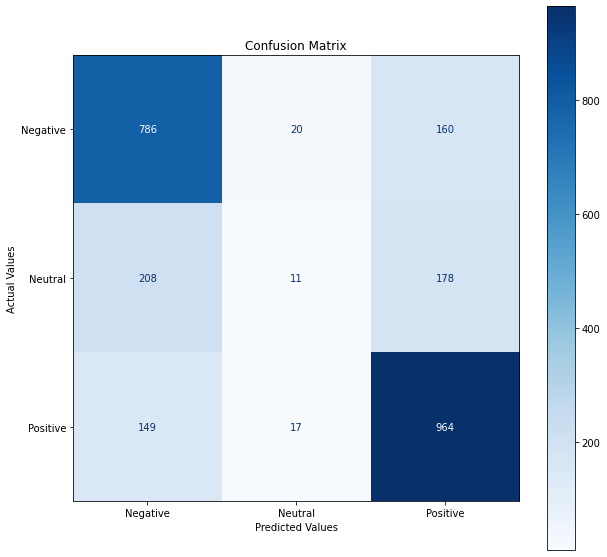

In [401]:
# Assesment of model errors
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_predict)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative','Neutral','Positive'])

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax,cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- Insights:
    - we can see the model predicts Positive reviews more easily than neutral reviews
    - remember our neutral reviews were a minority class in the dataset
    - that could be one of the reasons
    - next let's see if we can leverage contextual representation and improve our prediction performance

#### 4.3 Pretrained large lanugage model (DistilBert)

In [429]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm.auto import tqdm

from transformers import get_scheduler, get_linear_schedule_with_warmup
from transformers import DistilBertModel, DistilBertTokenizer
from datasets import Dataset
from collections import defaultdict

In [472]:
# dataset
df_pre = df[['content', 'label', 'score']].copy()
df_pre

,content,label,score
0,I cannot open the app anymore,0,1
1,I have been begging for a refund from this app for over a month and nobody is replying me,0,1
2,Very costly for the premium version (approx Indian Rupees 910 per year). Better to download the premium version of this app from apkmos website and use it. Microsoft to do list app is far more better.,0,1
3,"Used to keep me organized, but all the 2020 UPDATES have made a mess of things !!! Y cudn't u leave well enuf alone ??? Guess ur techies feel the need to keep making changes to justify continuing to collect their salary !!! 🤤🤤🤤",0,1
4,Dan Birthday Oct 28,0,1
...,...,...,...
12490,"I really like the planner, it helps me achieve my tasks, goals & have an avenue to scribe my ideas down. Double thumbs up!",2,5
12491,😁****😁,2,5
12492,Very useful apps. You must try it,2,5
12493,Would pay for this if there were even more additions and updates. Absolutely love it and wish they would develop it even further,2,5


In [473]:
# prepare splits and save for huggingface dataset for easier preprocessing
train_df, test_df = train_test_split(df_pre, stratify=df_pre['label'], test_size=0.2, random_state=42) 
val_df, test_df = train_test_split(test_df, stratify=test_df['label'], test_size=0.5, random_state=42) 

In [474]:
train_ds = Dataset.from_pandas(train_df, split="train", preserve_index=False)
val_ds = Dataset.from_pandas(val_df, split="val", preserve_index=False)
test_ds = Dataset.from_pandas(test_df, split="test", preserve_index=False)

In [407]:
# prepare our dataset for model
# tokenization
MODEL_NAME = 'K:\Models\distilbert-base-uncased' # ('distilbert-base-uncased')
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

In [408]:
# tokenize function
def tokenize_text(input_review):
    return tokenizer(input_review['content'], max_length = 150, padding='max_length', truncation = True, return_tensors='pt')

In [409]:
# test tokenizer 
tokenizer.decode(tokenizer("Hello 😁 😂")['input_ids'])

'[CLS] hello [UNK] [UNK] [SEP]'

- Insights:
    - we need some way to handle emojies
    - we can convert them to their meaning text by using a python package like "emoji"

In [410]:
# handling emojis
import emoji
import re

processed_text = emoji.demojize('Hello 😁 😂')
processed_text = re.sub("[:_]"," ",processed_text) # clean text
print(processed_text)
tokenizer.decode(tokenizer(processed_text)['input_ids'])

Hello  beaming face with smiling eyes   face with tears of joy 


'[CLS] hello beaming face with smiling eyes face with tears of joy [SEP]'

In [411]:
# updated tokenizer function
def tokenize_text_emojies(input_review):
    output = []
    for review in input_review['content']:
        review = emoji.demojize(review) 
        review = re.sub("[:_]"," ",review)
        output.append(review)
        
    return tokenizer(output, max_length = 150, padding='max_length', truncation = True, return_tensors='pt')

In [475]:
train_tokenized = train_ds.map(tokenize_text_emojies, batched=True, batch_size=None)
val_tokenized = val_ds.map(tokenize_text_emojies, batched=True, batch_size=None)
test_tokenized = test_ds.map(tokenize_text_emojies, batched=True, batch_size=None)

train_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/9971 [00:00<?, ? examples/s]

Map:   0%|          | 0/1246 [00:00<?, ? examples/s]

Map:   0%|          | 0/1247 [00:00<?, ? examples/s]

In [423]:
# test tokenization
print(train_ds[125])
tokenizer.decode(train_tokenized[125]['input_ids'])

{'content': 'Very good😛👍', 'label': 2}


'[CLS] very good face with tongue thumbs up [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [476]:
# Set up dataloaders
BATCH_SIZE = 64

train_loader = DataLoader(dataset=train_tokenized, batch_size=BATCH_SIZE, shuffle=True, num_workers=1, drop_last=True, )
val_loader = DataLoader(dataset=val_tokenized, batch_size=BATCH_SIZE, num_workers=1, drop_last=True, )
test_loader = DataLoader(dataset=test_tokenized, batch_size=BATCH_SIZE, num_workers=1, drop_last=True, )

In [425]:
# Examples 
data = next(iter(train_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['label'].shape)

dict_keys(['label', 'input_ids', 'attention_mask'])
torch.Size([64, 150])
torch.Size([64, 150])
torch.Size([64])


In [384]:
# Build the Sentiment Classifier class 
class DistilbertClassifier(nn.Module):
    
    def __init__(self, n_classes, freeze_distill_bert=False):
        super(DistilbertClassifier, self).__init__()
        self.distill_bert = DistilBertModel.from_pretrained(MODEL_NAME)
        self.hidden_dim = self.distill_bert.config.hidden_size

        self.classifier = nn.Sequential(nn.Linear(self.hidden_dim, self.hidden_dim),
                                        nn.ReLU(),
                                        nn.Linear(self.hidden_dim, n_classes)
        )

        # Freeze the BERT model
        if freeze_distill_bert:
            for param in self.distill_bert.parameters():
                param.requires_grad = False
                
    # Forward propagaion class
    def forward(self, input_ids, attention_mask):

        distilbert_output = self.distill_bert(input_ids, attention_mask)
        
        last_hidden_state_cls = distilbert_output.last_hidden_state[:,0]
        
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [426]:
# Instantiate the model and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DistilbertClassifier(n_classes = 3, freeze_distill_bert=False)
model = model.to(device)

Some weights of the model checkpoint at K:\Models\distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [192]:
# load model 
# model.load_state_dict(torch.load("gpclassfier_model_state.bin"))

In [427]:
# testing
model_inputs = tokenize_text({'content':'I like this app very much'})

input_ids = model_inputs["input_ids"].to(device)
attention_mask = model_inputs["attention_mask"].to(device)

model.eval()
outputs = model(input_ids=input_ids, attention_mask=attention_mask).squeeze()

outputs

tensor([-0.0645,  0.0711, -0.1854], device='cuda:0',
       grad_fn=<SqueezeBackward0>)

In [430]:
# setup optimizer, learning rate scheduler and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

# learning rate scheduler
num_epochs = 5
num_training_steps = num_epochs * len(train_loader)

lr_scheduler = get_linear_schedule_with_warmup(optimizer,
                                               num_warmup_steps=0, 
                                               num_training_steps=num_training_steps)

In [432]:
# setup evaluation function
def eval_model(model, data_loader, loss_fn, device, n_examples):
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            scores = batch["label"].to(device)
            
            # Get model ouptuts
            model.eval()
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, scores)
            
            correct_predictions += torch.sum(preds == scores)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

In [433]:
# training loop
losses = []
history = defaultdict(list)
progress_bar = tqdm(range(num_training_steps))
 

for epoch in range(num_epochs):

    print("-" * 10)
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print("-" * 10)
    
    correct_predictions = 0
    best_accuracy = 0

    for batch in train_loader:
        
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        scores = batch["label"].to(device)
        
        model.train()
        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask
                       ).squeeze()
        
        _, preds = torch.max(outputs, dim=1)
        correct_predictions += torch.sum(preds == scores)
        
        loss = loss_fn(outputs, scores)
        losses.append(loss.item())

        loss.backward()
        
        # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    
    # epoch evaluate
    train_loss = np.mean(losses)
    train_acc = correct_predictions.double() / len(train_loader.dataset)
    print(f"Train loss {train_loss}, accuracy {train_acc}")
    
    val_acc, val_loss = eval_model(model, val_loader, loss_fn, device, len(val_loader.dataset))
    print(f"Eval loss {val_loss}, accuracy {val_acc}")
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'gpclassfier_model_state.bin')
        best_accuracy = val_acc

  0%|          | 0/775 [00:00<?, ?it/s]

----------
Epoch 1/5
----------
Train loss 0.720567145655232, accuracy 0.7003309597833718
Eval loss 0.6079263734190088, accuracy 0.7471910112359551
----------
Epoch 2/5
----------
Train loss 0.6435942527747923, accuracy 0.7737438571858389
Eval loss 0.5842506509078177, accuracy 0.7568218298555377
----------
Epoch 3/5
----------
Train loss 0.5958823450150028, accuracy 0.802025875037609
Eval loss 0.598746098970112, accuracy 0.7576243980738363
----------
Epoch 4/5
----------
Train loss 0.5585457355745377, accuracy 0.8285026577073513
Eval loss 0.6125525392984089, accuracy 0.7520064205457464
----------
Epoch 5/5
----------
Train loss 0.5288180372791905, accuracy 0.8438471567545883
Eval loss 0.6209943169041684, accuracy 0.7512038523274478


---

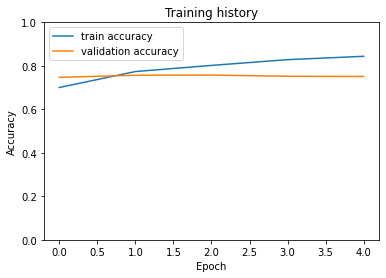

In [434]:
history['train_acc'] = [tensor.cpu().numpy() for tensor in history['train_acc']]
history['val_acc'] = [tensor.cpu().numpy() for tensor in history['val_acc']]

# Plot training and validation accuracy
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.show()

In [121]:
# five epochs and we have ~75% accuracy on validation dataset with sign of significant improvement

In [439]:
# lets see the test set evaluation
test_acc, _ = eval_model(model, test_loader, loss_fn, device, len(test_loader.dataset))
print(f"Test accuracy {test_acc * 100} %")

Test accuracy 73.37610264635124 %


- insights:
    - minor improvement compared to naive bayes model accuracy 70% 
    - next we investigate where the model fails and analyze its errors

---

### 5. Error Analysis

In [453]:
# setup get predictions function to analyze model errors
from torch.nn.functional import cross_entropy

def get_predictions(model, data_loader):

    predictions = []
    prediction_probs = []
    real_values = []
    losses = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            scores = batch["label"].to(device)
            
            model.eval()
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            loss = cross_entropy(outputs, scores, reduction='none')
            losses.extend(loss)
            
            _, preds = torch.max(outputs, dim=1)


            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(scores)
                        
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    losses = torch.stack(losses).cpu()
    return predictions, prediction_probs, real_values, losses

In [455]:
y_pred, y_pred_probs, y_test, losses = get_predictions(model, test_loader)
y_content = test_ds['content']

In [456]:
print(classification_report(y_test, y_pred, target_names=['Negative','Neutral','Positive']))

              precision    recall  f1-score   support

    Negative       0.77      0.82      0.80       472
     Neutral       0.31      0.24      0.27       190
    Positive       0.85      0.87      0.86       554

    accuracy                           0.75      1216
   macro avg       0.64      0.64      0.64      1216
weighted avg       0.74      0.75      0.74      1216



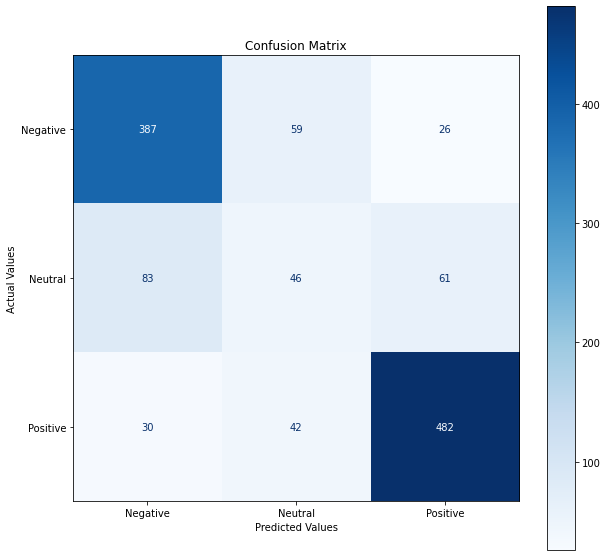

In [457]:
# Assesment of model errors
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative','Neutral','Positive'])

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax,cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- as expected most errors are on our minority class

In [184]:
# Now lets investigate model errors with two goals
# detect wrong labels
# detect problems of the dataset

In [478]:
total_length = len(losses) # total length is multiple of batch_size (we use that instead)
df_error_analysis = pd.DataFrame({'content':test_ds['content'][:total_length],
                                 'loss':losses,
                                 'predicted_label':y_pred,
                                 'actual_label':y_test,
                                 'original_score':test_ds['score'][:total_length]})

In [479]:
pd.set_option("max_colwidth", None)
df_error_analysis.sort_values('loss',ascending=False).head(10)

,content,loss,predicted_label,actual_label,original_score
1028,Nice integration with Teams & Planner. Would get an extra star if I could assign tasks directly from To Do.,5.545835,2,0,2
399,The app is easy to use and is very effective. I never experienced any technical failure or downtime.,5.369763,2,0,1
271,This is by far the best To-Do app. I gave it 2 stars because it enforces us to use Microsoft Account for sharing the lists.,5.248695,2,0,2
945,Awesome ...increase ur productivity,5.095391,2,0,2
764,The inspiration posters are not loading/viewable,5.052750,0,2,4
910,Good 😶👏👍,4.967635,2,0,2
314,I think that forest is so good,4.917964,2,0,2
253,"This is a great app. It gets two stars because I paid for it but it \nfrequently nags me to review it. Well, here's your review.",4.844963,2,0,2
435,"As a user of GTasks (owned by TickTick), how do I FULLY synchronise my data with the cloud (preferably Google but will make do with the TickTick servers). I pay for this service but only 40% of my tasks are backed up on TickTick server/cloud. Any and all advice much appreciated. kind Regards John Collington",4.712864,2,0,2
533,"I would love to do a one/life time purchase for this app. Too bad I hate subscription based so sorry, I'd rather spend my money for something unproductive than this app.",4.666218,0,2,4


- Insights:
    - the model predicted some of the labels incorrectly.
    - it seems that there are quite few examples that are labeled wrong too.
    - for example at index 910 **"Good 😶👏👍"** predicted as positive but the actual label is negative (2 stars originally)
        - which hints that it might be a mislabeled review
    - another example at index 945 **"Awesome ...increase ur productivity"** predicted as positive actual label is negative
        - either it is mislabeled review or "increase ur productivity" was meant as sarcasm for example and not a positive feedback
        - this is a reflection of why natural language understanding can be challenging
            - subjectivity : language can be influenced by personal opinions, feelings, and experiences, leading to variations in interpretation or expression based on individual perspectives
            

### 6. Next steps and ideas to consider next
    1. increase dataset, if possible with more quality labels
    2. use oversampling/undersampling techniques to solve the minority class problem (Neutral)
    2. use domain adaptation to increase performance by using (same or another) reviews dataset
    3. depending on your target audience consider training for multilanguages 
    4. add another machine learning model on top of our model to extract insights from filtered feedback